In [1]:
from string import ascii_letters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
from pydoc import help
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

#Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

## Helper methods

In [3]:
''' Exploratory Analysis ''' 
def expl(data):
    return print(data.shape), print(data.count()), print(data.columns)
           

In [4]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [37]:
class Performance:

    @staticmethod
    def get_perf(y, y_pred):
        '''
        This method outputs several performance metrics for classification.
        '''

        # Gets Confusion Matrix
        #conf_matrix = metrics.confusion_matrix(y_true = y, y_pred = y_pred)

        # Gets Accuracy
        accuracy = metrics.accuracy_score(y_true = y, y_pred = y_pred)

        # Gets Recall
        recall = metrics.recall_score(y_true = y, y_pred = y_pred)

        # Gets Precision
        precision = metrics.precision_score(y_true = y, y_pred = y_pred)

        # F1
        f1 = metrics.f1_score(y_true = y, y_pred = y_pred)

        return {'accuracy': accuracy, 'recall': recall,
                'precision': precision, 'F1': f1}

In [5]:
''' Makes binary variables and sets NaNs to 0 '''
def do_simple_preprocessing(dframe):
    # make binary variables
    # new_dframe = pd.get_dummies(dframe)
    
    #float_columns = dframe.select_dtypes(['float64', 'int64']).columns
    #dframe[float_columns][dframe.isnull()] = 0
    
    #dframe.dropna(inplace=True)
    dframe[dframe.isnull()] = 0
    
    # set nans to 0
    #dframe[dframe.isnull()] = None
    
    return dframe

### train data

In [6]:
raw_data_train = pd.read_csv('/home/xxx/MScBI/S4/ML/exer1/data/KDD/all/cup98ID.shuf.5000.train.csv', sep = ',',
            error_bad_lines = False, low_memory = False,
            skip_blank_lines = True, na_values = [' '],
            keep_default_na = True, verbose = True)

Tokenization took: 46.03 ms
Type conversion took: 93.27 ms
Parser memory cleanup took: 1.18 ms


In [7]:
raw_data_train.head(10)

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_B,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,9501,ARG,0,TX,79329,NaN,NaN,4401,0,NaN,...,0,0,L,3,G,X,X,X,56.0,C
1,9401,AML,1,OK,74135,NaN,NaN,3901,0,NaN,...,0,0,L,4,E,X,X,X,32.0,B
2,9401,ARG,0,NV,89117,NaN,NaN,0,1,NaN,...,0,0,L,1,F,X,X,X,20.0,B
3,9601,IWD,1,MI,48813,NaN,NaN,5401,0,NaN,...,0,0,L,1,F,X,X,X,37.0,B
4,9401,SYN,1,CA,94070,NaN,NaN,0,0,NaN,...,0,0,L,2,F,X,X,X,2.0,A
5,9501,CHT,0,IL,62024,NaN,NaN,4401,0,NaN,...,0,1,L,2,G,X,X,X,50.0,A
6,9501,MIC,0,CA,90046,NaN,NaN,0,0,NaN,...,0,0,L,3,E,X,X,X,10.0,A
7,9401,COK,0,KS,66215,NaN,NaN,0,0,NaN,...,0,0,L,1,F,X,X,X,12.0,B
8,9312,FRC,0,WA,98231-,NaN,NaN,0,0,NaN,...,0,0,L,2,G,X,X,X,37.0,C
9,9601,DPH,28,MI,49506,NaN,NaN,0,0,NaN,...,0,0,L,2,G,X,X,X,5.0,B


In [8]:
## column variances

In [9]:
dat_var = raw_data_train.var()
dat_var.index[dat_var < 0.005]

Index(['ADATE_2', 'ADATE_3', 'ADATE_5', 'ADATE_15', 'ADATE_20', 'ADATE_23',
       'ADATE_24'],
      dtype='object')

### test data

In [10]:
raw_data_test = pd.read_csv('/home/xxx/MScBI/S4/ML/exer1/data/KDD/all/cup98ID.shuf.5000.test.csv', sep = ',',
            error_bad_lines = False, low_memory = False,
            skip_blank_lines = True, na_values = [' '],
            keep_default_na = True, verbose = True)

Tokenization took: 44.47 ms
Type conversion took: 75.31 ms
Parser memory cleanup took: 0.96 ms


In [11]:
raw_data_test["CONTROLN"].head()

0    177658
1     97648
2    116053
3    109240
4     93585
Name: CONTROLN, dtype: int64

In [12]:
raw_data_validate = pd.read_csv('/home/xxx/MScBI/S4/ML/exer1/data/KDD/all/cup98ID.shuf.5000.sampleSolution.csv', sep = ',',
            error_bad_lines = False, low_memory = False,
            skip_blank_lines = True, na_values = [' '],
            keep_default_na = True, verbose = True)

Tokenization took: 0.42 ms
Type conversion took: 1.04 ms
Parser memory cleanup took: 0.01 ms


In [13]:
raw_data_validate.head()

,CONTROLN,TARGET_B
0,177658,0
1,97648,0
2,116053,0
3,109240,0
4,93585,0


In [14]:
## remove control numbers from datasets
controlnr_column = "CONTROLN"
controlNR_train = raw_data_train[controlnr_column]
controlNR_test = raw_data_test[controlnr_column]

raw_data_train.drop([controlnr_column], axis=1, inplace=True)
raw_data_test.drop([controlnr_column], axis=1, inplace=True)

# drop y from train just to have same dimensions
y_train = raw_data_train["TARGET_B"]
y_test = raw_data_validate["TARGET_B"]
raw_data_train.drop(["TARGET_B"], axis=1, inplace=True)

Must be true

In [15]:
assert raw_data_train.shape == raw_data_test.shape

In [16]:
## categorical variables imputation
raw_data_train_t = DataFrameImputer().fit_transform(raw_data_train)
raw_data_test_t = DataFrameImputer().fit_transform(raw_data_test)
#raw_data_train_t.head()


In [17]:
#raw_data_train.STATE.apply(pd.to_numeric)

Align dimensions in train and test data

In [18]:
all_data = pd.concat((raw_data_train_t,raw_data_test_t))
for column in all_data.select_dtypes(include=[np.object]).columns:
    #print(column, all_data[column].unique())
    raw_data_train_t[column] = raw_data_train_t[column].astype('category', categories = all_data[column].unique())
    raw_data_test_t[column] = raw_data_test_t[column].astype('category', categories = all_data[column].unique())

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


In [19]:
all_data.shape

(5000, 478)

In [20]:
assert raw_data_train_t.shape == raw_data_test_t.shape

Make binary variables

In [21]:
X_dummies = pd.get_dummies(raw_data_train_t)
X_test_dummies = pd.get_dummies(raw_data_test_t)

In [22]:
X_dummies.shape

(2500, 6537)

In [23]:
X_test_dummies.shape

(2500, 6537)

In [24]:
assert X_dummies.shape == X_test_dummies.shape

## Target class distribution

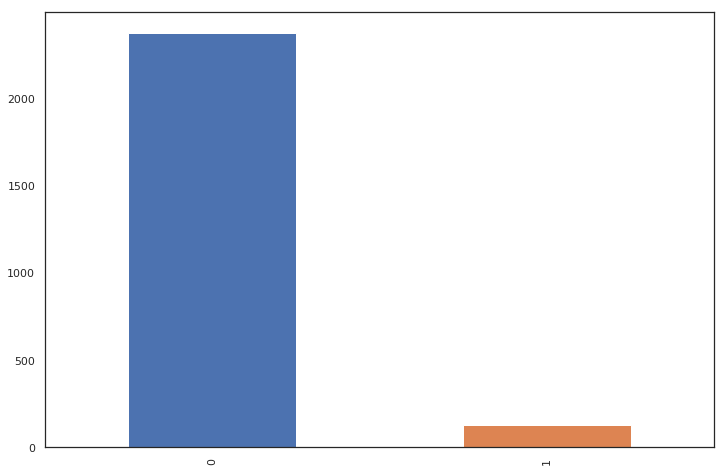

In [96]:
raw_data_train['TARGET_B'].value_counts().plot(kind='bar')

## Visualize correlations

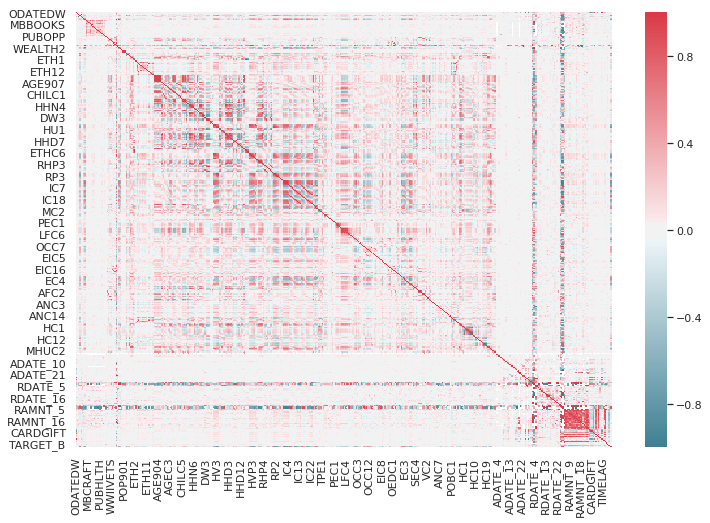

In [101]:
sns.set(style="white")

# Compute the correlation matrix
corr = raw_data_train.corr()
#mask =  np.tri(corr.shape[0], k=-1)
#corr = np.ma.array(corr, mask=mask)

## Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,)

## Remove highly correlated columns

In [29]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [102]:
raw_data_uncorrelated = trimm_correlated(raw_data_train, 0.8)

In [103]:
expl(raw_data_uncorrelated)

(2500, 257)
ODATEDW     2500
TCODE       2500
DOB         2500
CLUSTER     2427
NUMCHLD      348
INCOME      1960
WEALTH1     1327
HIT         2500
MBCRAFT     1095
MBGARDEN    1095
MBBOOKS     1095
MBCOLECT    1095
MAGFAML     1095
MAGFEM      1095
MAGMALE     1095
PUBGARDN    1095
PUBCULIN    1095
PUBHLTH     1095
PUBDOITY    1095
PUBNEWFN    1095
PUBPHOTO    1095
PUBOPP      1095
DATASRCE    1960
MALEMILI    2500
MALEVET     2500
VIETVETS    2500
WWIIVETS    2500
LOCALGOV    2500
STATEGOV    2500
FEDGOV      2500
            ... 
ADATE_17    1766
ADATE_18    1939
ADATE_19    1819
ADATE_20    1149
ADATE_21    1570
ADATE_22    1823
MAXADATE    2500
CARDPM12    2500
NUMPRM12    2500
RDATE_5        0
RDATE_7      255
RDATE_9      431
RDATE_10     244
RDATE_13     315
RDATE_17     218
RDATE_19     389
RDATE_20     183
RDATE_21     238
RDATE_24     461
RAMNT_5        0
RAMNT_7      255
RAMNTALL    2500
NGIFTALL    2500
MINRDATE    2500
MAXRDATE    2500
LASTDATE    2500
TIMELAG     2228
TA

(None, None, None)

257 columns left after removing highly correlated columns. 480 columns initially

## Baseline with Naive Bayes (no X preprocessing)

In [25]:
y = y_train
X = X_dummies

X_test = X_test_dummies

In [26]:
X.head()

,ODATEDW,TCODE,DOB,CLUSTER,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,...,MDMAUD_F_X,MDMAUD_F_1,MDMAUD_F_2,MDMAUD_A_X,MDMAUD_A_L,MDMAUD_A_C,GEOCODE2_C,GEOCODE2_B,GEOCODE2_A,GEOCODE2_D
0,9501,0,4401,44.0,54.000000,1.436782,2.000000,5.401658,0,0.13242,...,1,0,0,1,0,0,1,0,0,0
1,9401,1,3901,24.0,59.000000,1.436782,5.000000,8.000000,18,0.00000,...,1,0,0,1,0,0,0,1,0,0
2,9401,0,0,11.0,61.297747,1.436782,7.000000,5.401658,0,0.13242,...,1,0,0,1,0,0,0,1,0,0
3,9601,1,5401,39.0,44.000000,1.436782,6.000000,5.401658,0,0.13242,...,1,0,0,1,0,0,0,1,0,0
4,9401,1,0,11.0,61.297747,1.436782,3.906122,5.401658,0,0.13242,...,1,0,0,1,0,0,0,0,1,0


Find non numerical columns

In [27]:
#categorical_columns = X.select_dtypes(['object']).columns
#X[categorical_columns].head(5)

Make binary variables

Simply put all nans to 0 (for baseline)

In [28]:
#X = do_simple_preprocessing(X)
#np.any(np.isnan(X))


#np.all(np.isfinite(X))
X.dropna(axis='columns', inplace=True)
X_test.dropna(axis='columns', inplace=True)

In [29]:
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets 
model.fit(X, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [31]:
#Predict Output 
y_predicted= model.predict(X_test)
#print(predicted)

In [43]:
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
# Confusion Matrix
print (pd.crosstab(y_test, y_predicted, rownames = ['actual'], colnames = ['preds']))

preds      0  1
actual         
0       2492  8


In [41]:
# Gets performance
perf_model1 = Performance.get_perf(y_test, y_predicted)

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [44]:
data = [controlNR_test.values, y_predicted]
data

[array([177658,  97648, 116053, ..., 139123, 179951,  68808]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [45]:
df = pd.DataFrame()
df["CONTROLN"] = controlNR_test.values
df["TARGET_B"] = y_predicted
df.head()

,CONTROLN,TARGET_B
0,177658,0
1,97648,0
2,116053,0
3,109240,0
4,93585,0


In [46]:
df.to_csv('solution-1.csv', index=False)